<a href="https://colab.research.google.com/github/Diana-codes/CropSenseAI_model_training/blob/main/Summative_Intro_to_ml_Diana_Ruzindana_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CropSense AI: Crop Disease Detection in Rwanda

Objective: This notebook explores classification models for plant disease detection using classical ML and neural networks, applying optimization techniques to improve performance.

A Notebook detailing the following

* Project name





**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



Step 1: Setup and Install Dependencies

In [1]:
!pip install tensorflow tensorflow-datasets seaborn joblib


Step 2: Imports & Global Setup

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from joblib import dump

# SECTION 1: Model Architecture

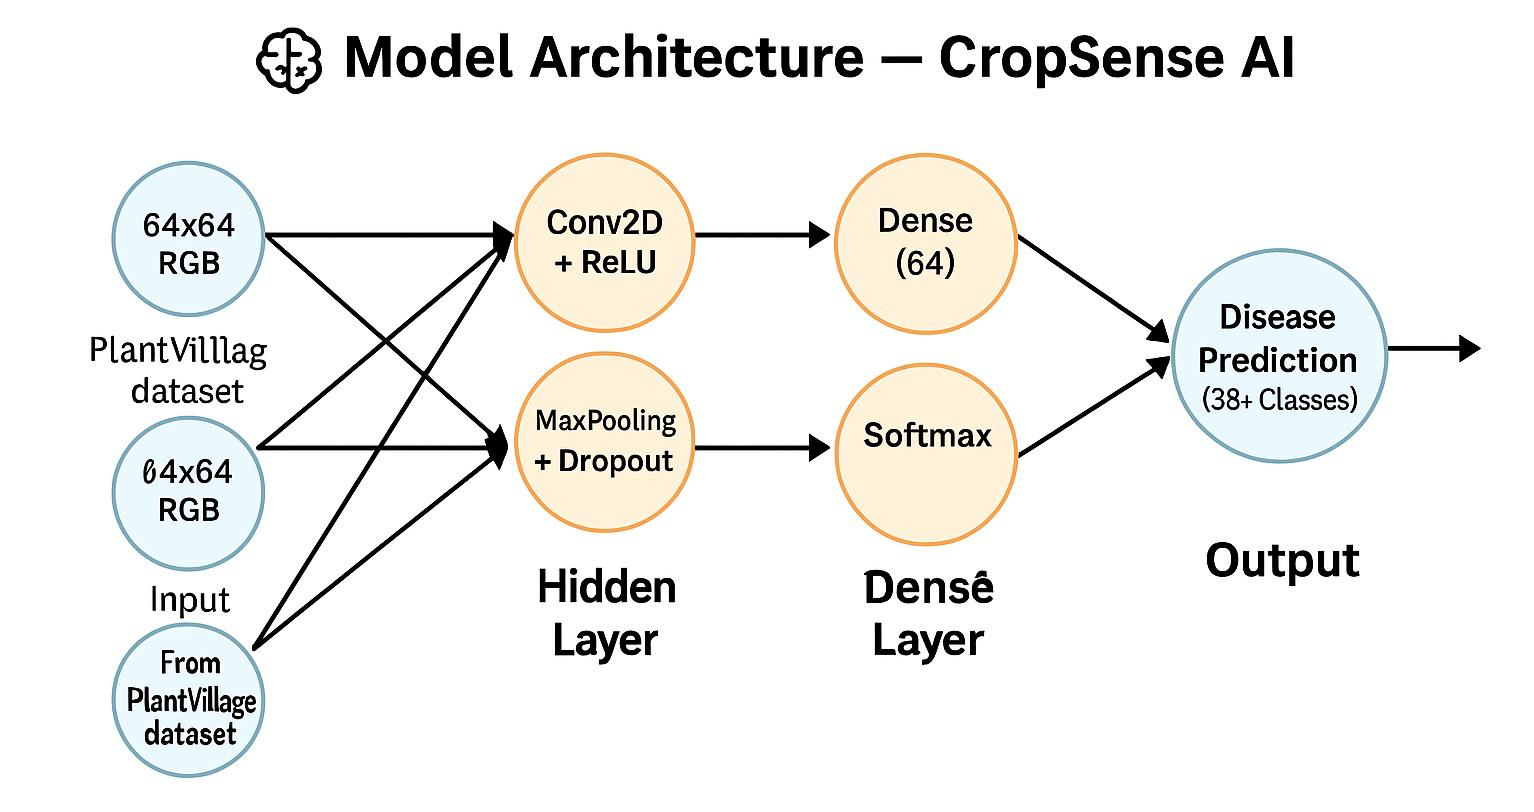

In [5]:
from IPython.display import Image, display
display(Image("model_architecture.png", width=400))

Step 3: Load PlantVillage Dataset



In [6]:
# Load PlantVillage from TFDS
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Resize, normalize, and batch
IMG_SIZE = 64
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
ds_val = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(1)

# Check class names
class_names = ds_info.features['label'].names
print("Detected classes:", class_names)
NUM_CLASSES = len(class_names)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.IX0WJE_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Detected classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_

Step 4: Define define_model() Function

In [7]:
def define_model(optimizer='adam', regularizer=None, early_stopping=False, dropout_rate=0.3, lr=0.001, layers_num=2):
    model = models.Sequential()
    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

    for _ in range(layers_num):
        model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizer))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    opt = tf.keras.optimizers.get(optimizer)
    opt.learning_rate = lr

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = []
    if early_stopping:
        callbacks.append(EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True))

    return model, callbacks

Instance 1: Baseline Model (No Optimization)

In [8]:
# Instance 1: Baseline model (no optimizer tuning, no early stopping, default settings)

model_1, callbacks_1 = define_model(
    optimizer='adam',
    regularizer=None,
    early_stopping=False,
    dropout_rate=0.0,
    lr=0.001,
    layers_num=2
)

history_1 = model_1.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_1,
    verbose=1
)

# Save model
os.makedirs("saved_models", exist_ok=True)
model_1.save("saved_models/model_instance_1.keras")


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 279s 202ms/step - accuracy: 0.4615 - loss: 2.0243 - val_accuracy: 0.7244 - val_loss: 0.9050
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 307s 191ms/step - accuracy: 0.7634 - loss: 0.7721 - val_accuracy: 0.7895 - val_loss: 0.6650
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 233s 171ms/step - accuracy: 0.8282 - loss: 0.5524 - val_accuracy: 0.8521 - val_loss: 0.4789
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 227s 166ms/step - accuracy: 0.8621 - loss: 0.4354 - val_accuracy: 0.8484 - val_loss: 0.4901
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 224s 164ms/step - accuracy: 0.8806 - loss: 0.3713 - val_accuracy: 0.8675 - val_loss: 0.4230
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 264s 166ms/step - accuracy: 0.8967 - loss: 0.3139 - val_accuracy: 0.8905 - val_loss: 0.3578
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 260s 164ms/step - accuracy: 0.9138 - loss: 0.2639 - val_accuracy: 0.8958 - val_loss: 0.3426
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 164ms/step - ac

Evaluate & Visualize

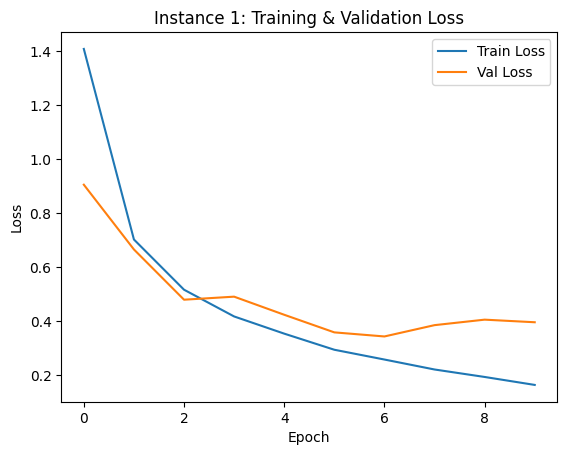

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━

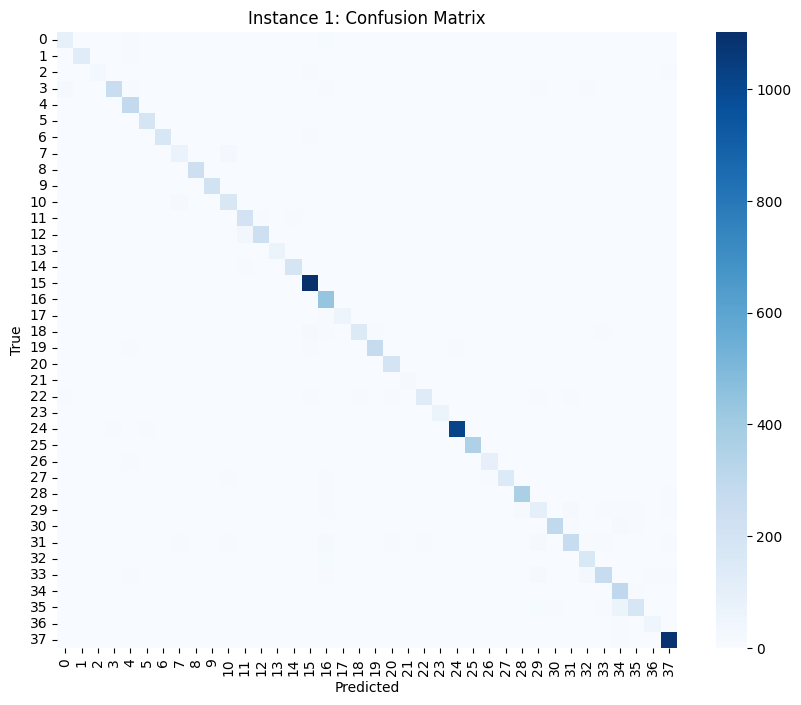

In [9]:
# Plot loss curve
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Val Loss')
plt.title("Instance 1: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate model on validation set
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_1.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 1 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Instance 1: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 2: RMSprop + L2 Regularization + Dropout + Early Stopping

In [10]:
l2_reg = regularizers.l2(0.01)

model_2, callbacks_2 = define_model(
    optimizer='rmsprop',
    regularizer=l2_reg,
    early_stopping=True,
    dropout_rate=0.3,
    lr=0.0005,
    layers_num=3
)

history_2 = model_2.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_2,
    verbose=1
)

# Save model
model_2.save("saved_models/model_instance_2.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 260s 190ms/step - accuracy: 0.2655 - loss: 3.0878 - val_accuracy: 0.4857 - val_loss: 2.0259
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 189ms/step - accuracy: 0.5527 - loss: 1.7159 - val_accuracy: 0.6557 - val_loss: 1.3138
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 256s 188ms/step - accuracy: 0.6444 - loss: 1.3469 - val_accuracy: 0.7436 - val_loss: 1.0265
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 257s 189ms/step - accuracy: 0.6979 - loss: 1.1571 - val_accuracy: 0.7551 - val_loss: 0.9764
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 259s 190ms/step - accuracy: 0.7329 - loss: 1.0314 - val_accuracy: 0.7415 - val_loss: 1.0073
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 259s 190ms/step - accuracy: 0.7555 - loss: 0.9558 - val_accuracy: 0.7938 - val_loss: 0.8432
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 279s 205ms/step - accuracy: 0.7755 - loss: 0.8946 - val_accuracy: 0.8152 - val_loss: 0.7541
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 260s 191ms/step - ac

Evaluation Cell

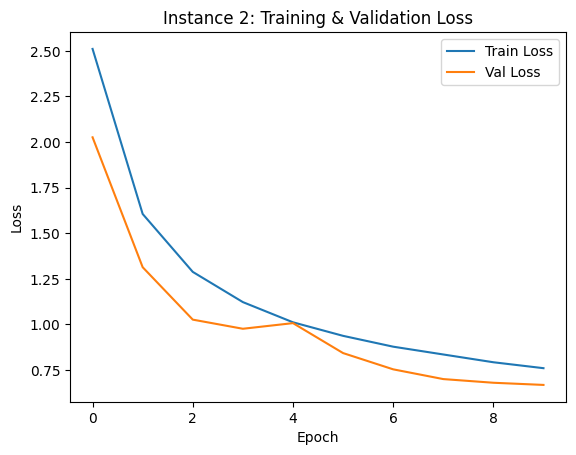

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━

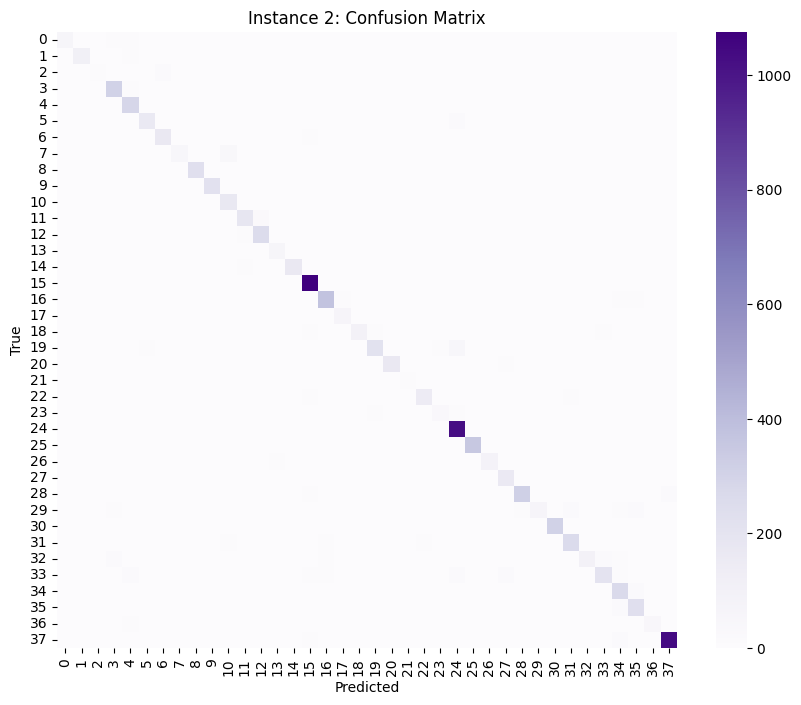

In [11]:
# Plot loss curve
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Val Loss')
plt.title("Instance 2: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_2.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 2 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Purples')
plt.title("Instance 2: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 3: Adam + L1 Regularization + Dropout + More Layers

In [12]:
l1_reg = regularizers.l1(0.01)

model_3, callbacks_3 = define_model(
    optimizer='adam',
    regularizer=l1_reg,
    early_stopping=True,
    dropout_rate=0.4,
    lr=0.0003,
    layers_num=4
)

history_3 = model_3.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_3,
    verbose=1
)

model_3.save("saved_models/model_instance_3.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 266s 193ms/step - accuracy: 0.0868 - loss: 7.9552 - val_accuracy: 0.1020 - val_loss: 3.3540
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 317s 190ms/step - accuracy: 0.1000 - loss: 3.3646 - val_accuracy: 0.1020 - val_loss: 3.3509
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 262s 190ms/step - accuracy: 0.0971 - loss: 3.3645 - val_accuracy: 0.1020 - val_loss: 3.3510
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 192ms/step - accuracy: 0.0988 - loss: 3.3636 - val_accuracy: 0.1020 - val_loss: 3.3502
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 283s 208ms/step - accuracy: 0.1012 - loss: 3.3632 - val_accuracy: 0.1020 - val_loss: 3.3501
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 257s 189ms/step - accuracy: 0.0976 - loss: 3.3601 - val_accuracy: 0.1020 - val_loss: 3.3506
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 267s 192ms/step - accuracy: 0.0974 - loss: 3.3639 - val_accuracy: 0.1020 - val_loss: 3.3510
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 318s 190ms/step - ac

 Evaluation Cell

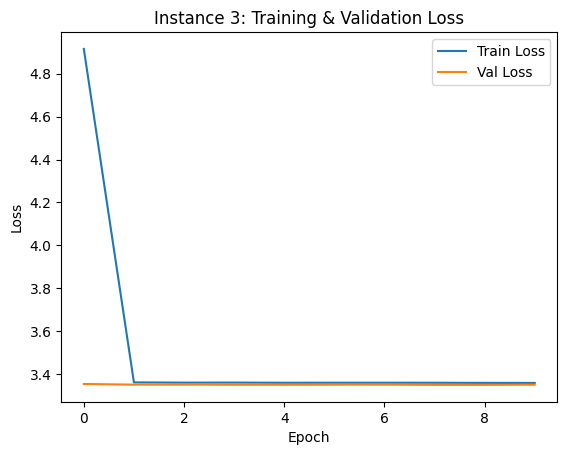

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/st

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Instance 3 Metrics:
Accuracy: 0.1020
Precision: 0.0027
Recall: 0.0263
F1-score: 0.0049


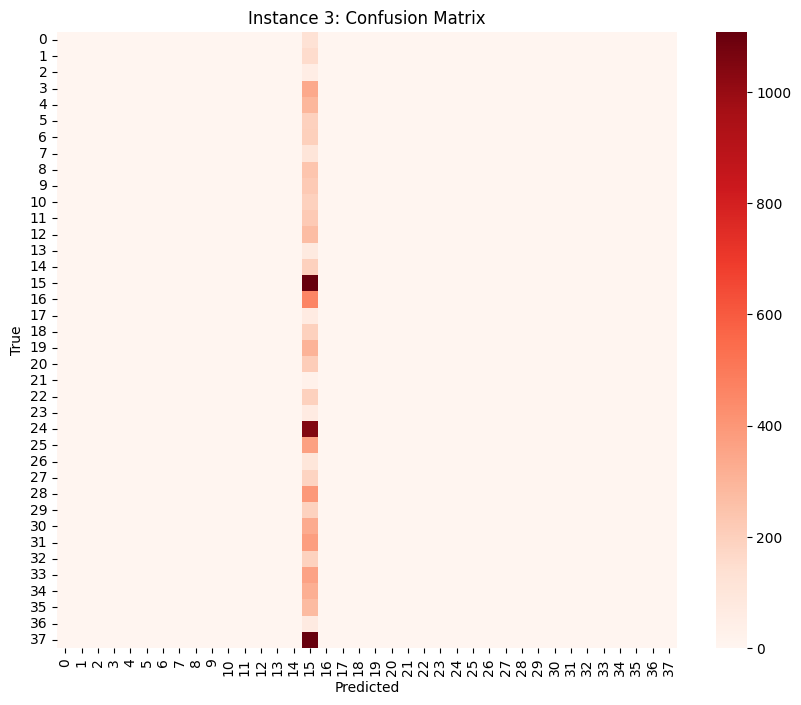

In [13]:
# Plot loss curve
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Val Loss')
plt.title("Instance 3: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_3.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 3 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Reds')
plt.title("Instance 3: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 4: RMSprop + L1_L2 Combo + NO EarlyStopping

In [14]:
l1_l2_reg = regularizers.l1_l2(l1=0.005, l2=0.005)

model_4, callbacks_4 = define_model(
    optimizer='rmsprop',
    regularizer=l1_l2_reg,
    early_stopping=False,
    dropout_rate=0.2,
    lr=0.0007,
    layers_num=3
)

history_4 = model_4.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_4,
    verbose=1
)

model_4.save("saved_models/model_instance_4.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 254s 185ms/step - accuracy: 0.2440 - loss: 4.0123 - val_accuracy: 0.4519 - val_loss: 2.2684
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 248s 182ms/step - accuracy: 0.4857 - loss: 2.1213 - val_accuracy: 0.5466 - val_loss: 1.8480
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 250s 183ms/step - accuracy: 0.5493 - loss: 1.8137 - val_accuracy: 0.5649 - val_loss: 1.7212
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 262s 183ms/step - accuracy: 0.5965 - loss: 1.6220 - val_accuracy: 0.4272 - val_loss: 2.1988
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 182ms/step - accuracy: 0.6244 - loss: 1.5031 - val_accuracy: 0.6444 - val_loss: 1.4584
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 249s 183ms/step - accuracy: 0.6474 - loss: 1.4136 - val_accuracy: 0.6638 - val_loss: 1.4039
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 264s 185ms/step - accuracy: 0.6727 - loss: 1.3404 - val_accuracy: 0.5949 - val_loss: 1.5820
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 262s 184ms/step - ac

Evaluation Cell

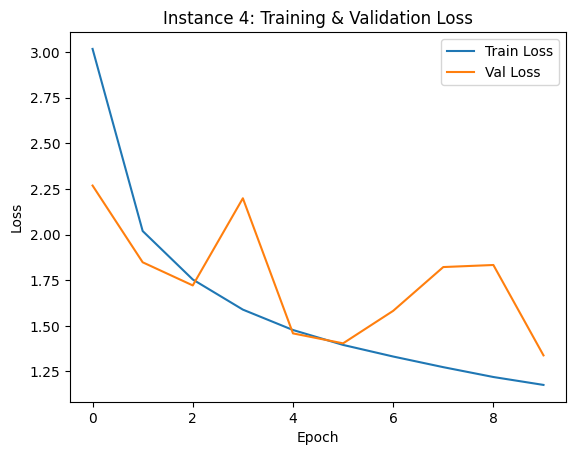

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

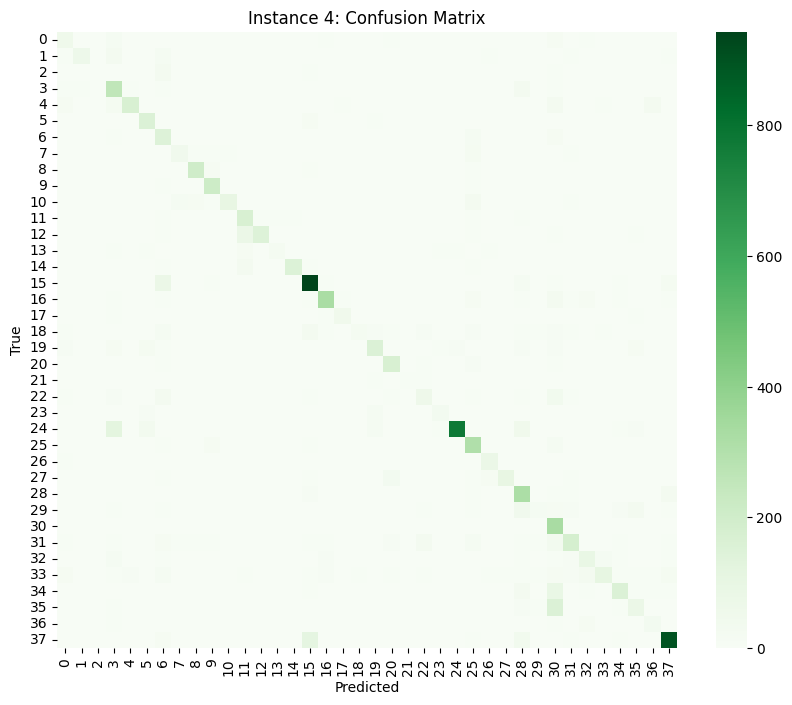

In [15]:
# Plot loss curve
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Val Loss')
plt.title("Instance 4: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_4.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 4 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Greens')
plt.title("Instance 4: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Instance 5: Adam + No Regularization + High Dropout + Tiny LR


In [16]:
model_5, callbacks_5 = define_model(
    optimizer='adam',
    regularizer=None,
    early_stopping=True,
    dropout_rate=0.5,
    lr=0.0001,
    layers_num=3
)

history_5 = model_5.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_5,
    verbose=1
)

model_5.save("saved_models/model_instance_5.keras")

Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 257s 187ms/step - accuracy: 0.1213 - loss: 3.3796 - val_accuracy: 0.2684 - val_loss: 2.9005
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 258s 189ms/step - accuracy: 0.2860 - loss: 2.6666 - val_accuracy: 0.4354 - val_loss: 2.2054
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 255s 187ms/step - accuracy: 0.4127 - loss: 2.1111 - val_accuracy: 0.5404 - val_loss: 1.8256
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 259s 190ms/step - accuracy: 0.4906 - loss: 1.8011 - val_accuracy: 0.6002 - val_loss: 1.5511
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 263s 191ms/step - accuracy: 0.5436 - loss: 1.5652 - val_accuracy: 0.6382 - val_loss: 1.3548
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 260s 189ms/step - accuracy: 0.5920 - loss: 1.3874 - val_accuracy: 0.6739 - val_loss: 1.1898
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 257s 189ms/step - accuracy: 0.6280 - loss: 1.2450 - val_accuracy: 0.7042 - val_loss: 1.0753
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 261s 188ms/step - ac

Evaluation Cell

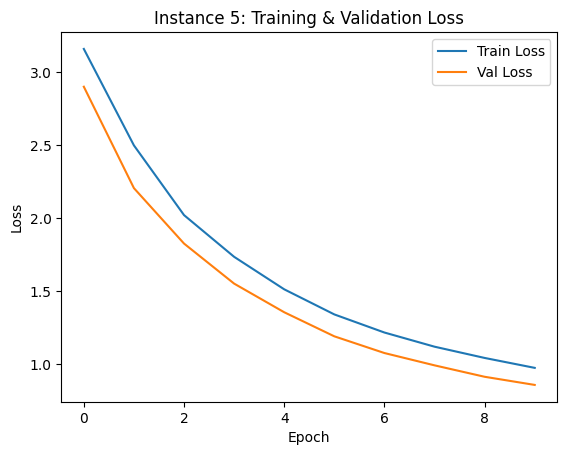

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━

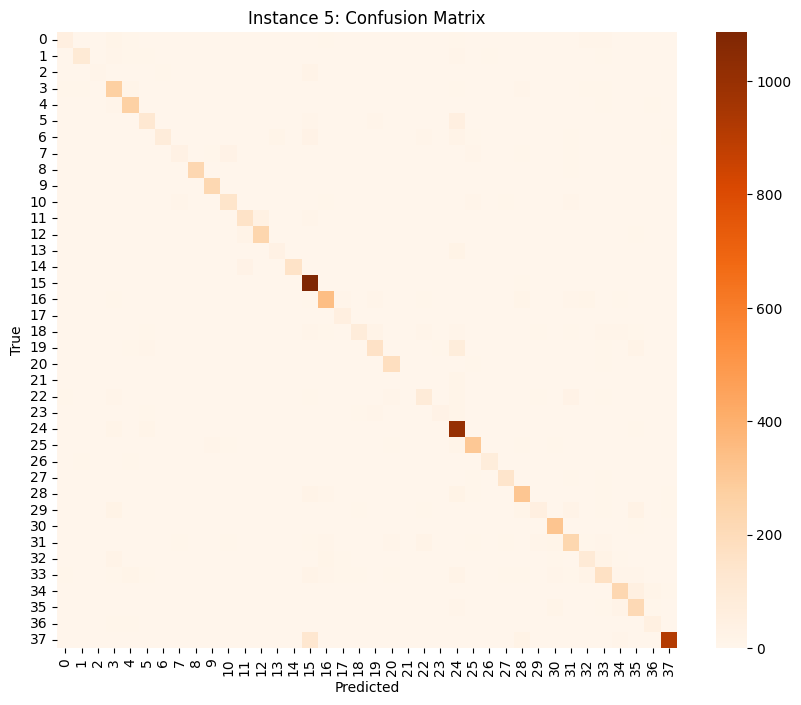

In [17]:
# Plot loss curve
plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Val Loss')
plt.title("Instance 5: Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluation
y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model_5.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Instance 5 Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Oranges')
plt.title("Instance 5: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()